Data: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [2]:
import os

import numpy as np
import pandas as pd
import cv2 as cv

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

%matplotlib inline

In [128]:
data_dir = './archive/'
train_dir = './archive/Train/'
test_path = './archive/Test/'

IMG_HEIGHT = 30
IMG_WIDTH = 30
CHANNELS = 3

In [129]:
LABELS = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' 
}

# Exploring Data

In [130]:
NUM_LABELS = len(LABELS.keys())
NUM_LABELS

43

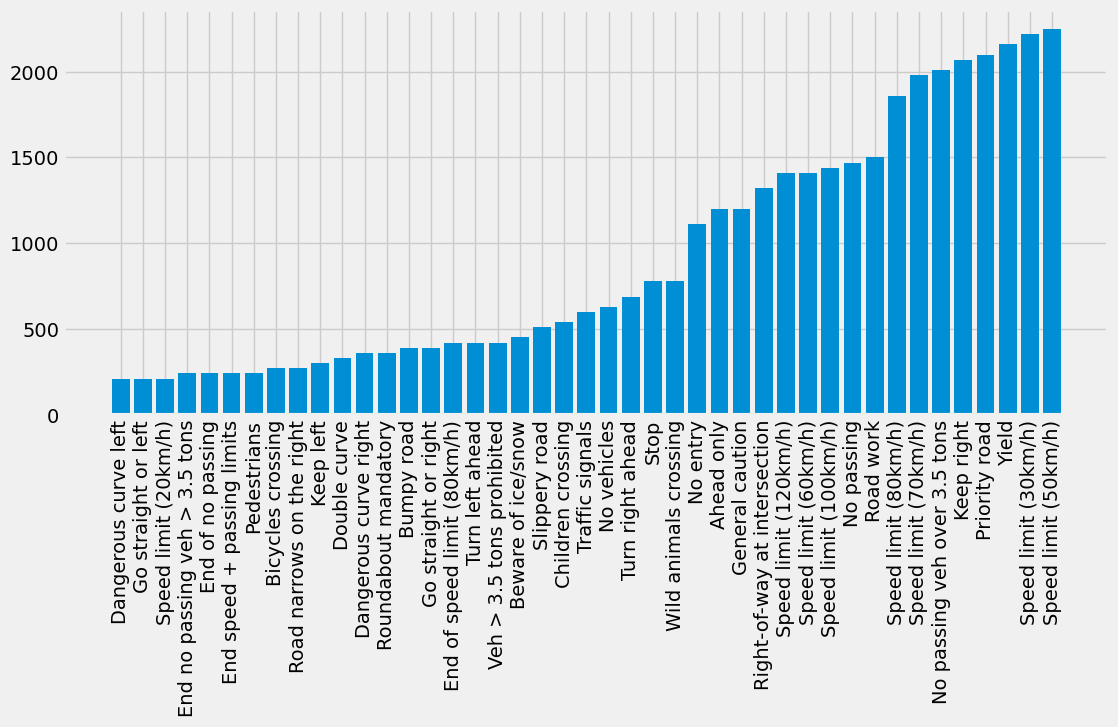

In [131]:
folders = np.array(os.listdir(train_dir))

train_count = []
train_label = []

for folder in folders:
    path = os.path.join(train_dir, folder)
    label_files = os.listdir(path)
    
    train_count.append(len(label_files))
    train_label.append(LABELS[int(folder)])

train_merged = zip(train_count, train_label)
train_sorted = sorted(train_merged)

y, x = zip(*train_sorted)

plt.figure(figsize=(12,5))
plt.bar(x, y)
plt.xticks(x, rotation='vertical')
plt.show();

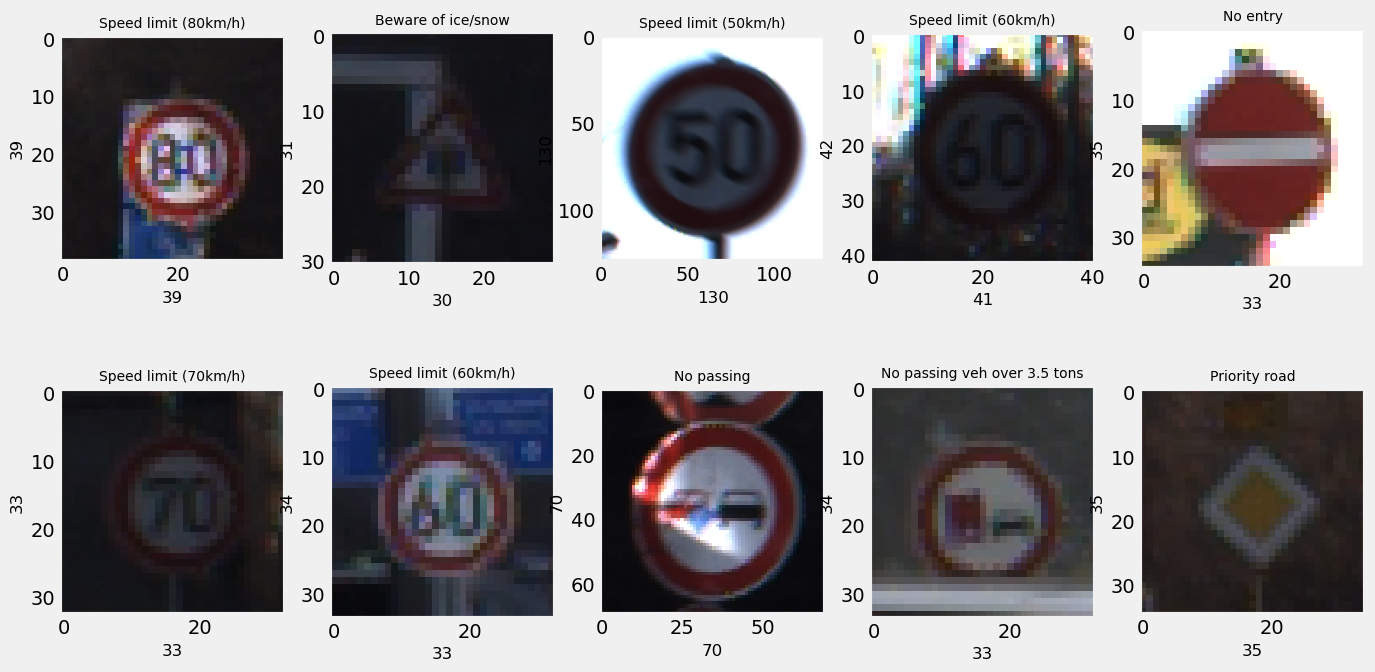

In [132]:
from matplotlib.image import imread

test_df = pd.read_csv(os.path.join(data_dir, 'Test.csv'))
imag_paths = test_df['Path'].values

plt.figure(figsize=(15, 8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    
    rand_num = np.random.randint(0, len(imag_paths))
    random_img_path = os.path.join(data_dir, imag_paths[rand_num])
    rand_img = imread(random_img_path)
    
    plt.title(LABELS[test_df['ClassId'][rand_num]], fontsize=10)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize=12)
    plt.ylabel(rand_img.shape[0], fontsize=12)

# Loading Images into memory

In [133]:
%%time

from PIL import Image

train_image = []
train_labels = []

for i in range(NUM_LABELS):
    path = os.path.join(train_dir, str(i))
    images = os.listdir(path)
    
    for image in images:
        image_path = os.path.join(path, image)
        
        img = cv.imread(image_path)
        img = Image.fromarray(img, 'RGB')
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))
        img = np.array(img)
        
        train_image.append(img)
        train_labels.append(i)
    
train_image = np.array(train_image)
train_labels = np.array(train_labels)

train_image.shape, train_labels.shape

CPU times: total: 18 s
Wall time: 18.1 s


((39209, 30, 30, 3), (39209,))

In [134]:
train_labels = to_categorical(train_labels, NUM_LABELS)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [135]:
len(train_labels)

39209

In [136]:
len(train_labels[0])

43

In [137]:
train_labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [138]:
train_image[0].shape

(30, 30, 3)

In [139]:
train_image[0]

array([[[ 80,  78,  75],
        [ 78,  76,  74],
        [ 84,  86,  85],
        ...,
        [ 74,  75,  68],
        [ 68,  69,  65],
        [ 66,  67,  66]],

       [[ 86,  84,  83],
        [ 82,  80,  80],
        [ 83,  88,  88],
        ...,
        [ 78,  77,  73],
        [ 75,  78,  76],
        [ 78,  80,  80]],

       [[ 80,  78,  78],
        [ 86,  85,  86],
        [ 90,  89,  90],
        ...,
        [ 71,  74,  71],
        [ 69,  74,  73],
        [ 74,  78,  78]],

       ...,

       [[139, 134, 133],
        [132, 127, 123],
        [125, 121, 112],
        ...,
        [ 89,  95,  94],
        [ 91,  98,  97],
        [ 99, 103,  99]],

       [[ 99,  95,  91],
        [103,  98,  91],
        [ 90,  86,  75],
        ...,
        [ 96, 102, 104],
        [104, 113, 110],
        [ 98, 104,  96]],

       [[ 87,  84,  85],
        [107, 101,  95],
        [ 81,  76,  63],
        ...,
        [ 95, 103, 103],
        [ 90, 102,  99],
        [ 89,  97,  90]]

In [140]:
train_image = train_image/255.0

In [141]:
train_image

array([[[[0.31372549, 0.30588235, 0.29411765],
         [0.30588235, 0.29803922, 0.29019608],
         [0.32941176, 0.3372549 , 0.33333333],
         ...,
         [0.29019608, 0.29411765, 0.26666667],
         [0.26666667, 0.27058824, 0.25490196],
         [0.25882353, 0.2627451 , 0.25882353]],

        [[0.3372549 , 0.32941176, 0.3254902 ],
         [0.32156863, 0.31372549, 0.31372549],
         [0.3254902 , 0.34509804, 0.34509804],
         ...,
         [0.30588235, 0.30196078, 0.28627451],
         [0.29411765, 0.30588235, 0.29803922],
         [0.30588235, 0.31372549, 0.31372549]],

        [[0.31372549, 0.30588235, 0.30588235],
         [0.3372549 , 0.33333333, 0.3372549 ],
         [0.35294118, 0.34901961, 0.35294118],
         ...,
         [0.27843137, 0.29019608, 0.27843137],
         [0.27058824, 0.29019608, 0.28627451],
         [0.29019608, 0.30588235, 0.30588235]],

        ...,

        [[0.54509804, 0.5254902 , 0.52156863],
         [0.51764706, 0.49803922, 0.48235294]

In [142]:
X_train, X_val, y_train, y_val = train_test_split(train_image, train_labels, test_size=0.3, random_state=42, shuffle=True)

In [143]:
X_val

array([[[[0.16470588, 0.23137255, 0.41568627],
         [0.14901961, 0.21176471, 0.36862745],
         [0.12941176, 0.19607843, 0.29019608],
         ...,
         [0.16078431, 0.32156863, 0.54117647],
         [0.18431373, 0.32156863, 0.51372549],
         [0.25490196, 0.42745098, 0.66666667]],

        [[0.18431373, 0.25882353, 0.41176471],
         [0.15686275, 0.22745098, 0.34901961],
         [0.11372549, 0.19607843, 0.34509804],
         ...,
         [0.09803922, 0.23529412, 0.38039216],
         [0.07058824, 0.18823529, 0.22745098],
         [0.10588235, 0.24705882, 0.29411765]],

        [[0.18823529, 0.28627451, 0.45882353],
         [0.14117647, 0.24705882, 0.37647059],
         [0.10588235, 0.22352941, 0.4       ],
         ...,
         [0.1254902 , 0.24705882, 0.37254902],
         [0.08627451, 0.21176471, 0.28627451],
         [0.08627451, 0.21568627, 0.29411765]],

        ...,

        [[0.12156863, 0.20392157, 0.37254902],
         [0.14509804, 0.21960784, 0.35294118]

# Creating the model

In [144]:
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=train_image[0].shape))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(43, activation='softmax'))

In [145]:
lr = 0.001
epochs = 10

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [146]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 conv2d_44 (Conv2D)          (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 13, 13, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 11, 11, 64)      

# Training the model

In [147]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

In [148]:
%%time
history = model.fit(aug.flow(train_image, train_labels, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/10
1226/1226 [==============================] - 91s 73ms/step - loss: 1.3065 - accuracy: 0.6475 - val_loss: 0.0815 - val_accuracy: 0.9803
Epoch 2/10
1226/1226 [==============================] - 105s 85ms/step - loss: 0.2739 - accuracy: 0.9177 - val_loss: 0.0338 - val_accuracy: 0.9910
Epoch 3/10
1226/1226 [==============================] - 99s 81ms/step - loss: 0.1529 - accuracy: 0.9542 - val_loss: 0.0177 - val_accuracy: 0.9947
Epoch 4/10
1226/1226 [==============================] - 90s 74ms/step - loss: 0.1117 - accuracy: 0.9652 - val_loss: 0.0050 - val_accuracy: 0.9987
Epoch 5/10
1226/1226 [==============================] - 97s 79ms/step - loss: 0.0740 - accuracy: 0.9772 - val_loss: 0.0023 - val_accuracy: 0.9993
Epoch 7/10
1226/1226 [==============================] - 111s 90ms/step - loss: 0.0575 - accuracy: 0.9826 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 8/10
1226/1226 [==============================] - 101s 82ms/step - loss: 0.0530 - accuracy: 0.9836 - val_loss: 0.001

In [150]:
model.save('model.h5')

# Plotting metrics

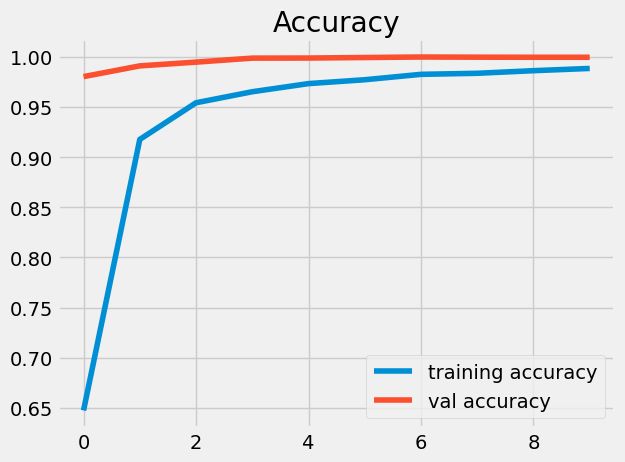

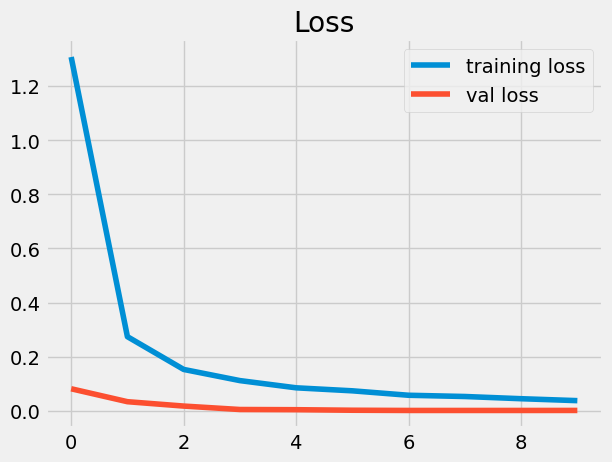

In [154]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.legend()
plt.show();

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show();